In [ ]:
# Checkout www.pygimli.org for more examples


# Simple fit

This tutorial shows how to do the simplest inversion case, a curve fit, by
setting up a custom forward operator. The function to be fitted is`

\begin{align}f(x) = A \cdot e^{-x/X}\end{align}

with the two unknown coefficients A (a signal  amplitude) and X (a decay rate).
Both A and X are assumed to be positive which is often the case for physical
properties. The easiest way to do this is via a logarithmic transformation of
the model vector (containing A and X) which is very easily done in pyGIMLi.

First we import the pygimli library under a short name pg and the numerics
library numpy. Additionally we load the python plotting module of the library
matplotlib. Both are contained in most python distributions and systems.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

We set up the modelling operator, i.e. to return ${\bf f}({\bf x})$ for
given model parameters A and X subsumed in a vector. In order to be able to
use operator in inversion, we derive from the abstract modelling base class.
The latter holds the main mimic of generating Jacobian and adminstrating the
model, the regularization and so on. The only function to overwrite is
**response()**. If no function **createJacobian** is provided, they are
computed by brute force (forward calculations with altered parameters).



In [2]:
class ExpModelling(pg.Modelling):
    """Exponential decay function modelling operator."""
    def __init__(self, xvec, verbose=False):
        """Initialize with storing x values."""
        super().__init__()
        self.x = xvec

    def response(self, model):
        """Model response, i.e. A*exp(-x/x0)."""
        return model[0] * pg.exp(-self.x / model[1])

    def createStartModel(self, dataVals):
        return pg.Vector([1.0, 3.0])

The init function saves the x vector and defines the parameterization, i.e.
two independent parameters (a 1D mesh with 1 cell and 2 properties).
The response function computes the function using A=model[0] and X=model[1]
The function startModel defines a meaningful starting vector. There are other
methods to set the starting model as inv.setModel() but this one is a default
one for people who use the class and forget about a starting model.



We first create an abscissa vector using numpy (note that pygimli also
provides an exp function and generate synthetic data with two arbitrary A and
X values.



In [19]:
x = np.arange(0, 10, 1e-2)
data = 10.5 * np.exp(- x / 550e-3)

We define an (absolute) error level and add Gaussian noise to the data.



In [21]:
error = 0.5
data += pg.randn(*data.shape) * error

Next, an instance of the forward operator is created. We could use it for
calculating the synthetic data using f.response([10.5, 0.55]) or just
f([10.5, 0.55]). We create a real-valued (R) inversion passing the forward
operator, the data. A verbose boolean flag could be added to provide some
output the inversion, another one prints more and saves files for debugging.



In [22]:
f = ExpModelling(x)
inv = pg.frameworks.MarquardtInversion(f)

We create a real-valued logarithmic transformation and apply it to the model.
Similar could be done for the data which are by default treated linearly.
We then set the error level that is used for data weighting. It can be a
float number or a vector of data length. One can also set a relative error.
Finally, we use an inversion style known as Marquardt scheme (pure local
damping with decreasing the regularization parameter subsequently) and start
with a relatively large regularization strength to avoid overshoot.
Finally run yields the coefficient vector and we plot some statistics.



In [27]:
coeff = inv.run(data, absoluteError=error, verbose=True)
print(inv.relrms(), inv.chi2())

11/04/24 - 15:50:35 - pyGIMLi - INFO - Created startmodel from forward operator: 2, min/max=1.000000/3.000000
11/04/24 - 15:50:35 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.ExpModelling object at 0x000002172EAC7060>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002172EAE98C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002172EAC6840>
min/max (data): -1.65/11.08
min/max (error): 4.51%/2.9e+04%
min/max (start model): 1/3
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   10.57
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    6.96 (dPhi = 34.10%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    2.54 (dPhi = 63.58%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.15 (dPhi = 54.70%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.14 (dPhi = 0.40%) lam: 20.0
#########################################

We see that after a few iterations the absolute rms value equals the noise
level corresponding to a chi-squared misfit value of 1 as it should be the
case for synthetic data. The relative rms (in %) is less relevant here but
can be for other applications. Additionally the ranges for model and model
response are given and the objective function consisting of data misfit and
model roughness times lambda. Note that due to the local regularization the
second term does not contribute to Phi.



We finally create a plotting figure and plot both data and model response.



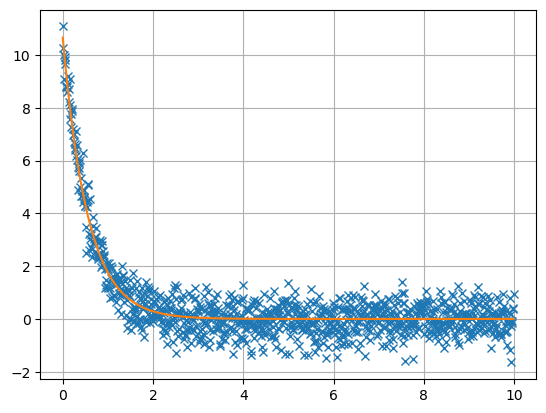

In [24]:
plt.figure()
plt.plot(x, data, 'x', x, inv.response, '-')
plt.grid(True)

The resulting model vector has a length of 2 and consists of the inverted A
and X values that are close to the synthetic values, being equivalent within
error bounds.



In [28]:
print(coeff)

2 [10.658116400343824, 0.5543542256605118]


If you are interested which way the inversion took, you can have a look at
the model history.



In [29]:
for model in inv.modelHistory:
    print(model)

plt.show()

2 [1.0, 3.0]
2 [2.6925778154045137, 1.1410971970118813]
2 [6.989047206841573, 0.5807642189191801]
2 [10.483467304959188, 0.5514532282883442]
2 [10.658116400343824, 0.5543542256605118]
